# Import all the tools needed

In [385]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.models import Sequential, clone_model
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, Input , Concatenate
from keras.utils import to_categorical
from keras.regularizers import l2, l1
from keras.optimizers import SGD
from keras.models import Model

# 2    Getting Started

In [501]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

""" Generate drawing modified
def generate_a_drawing(figsize, U, V, noise ) :
    noise = np.random.random(1)[0]*100
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata1 = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata, imdata1 , noise"""
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


"""im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')"""


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3    Simple Classification

Generating the training set

In [503]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
X_train.shape

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


(300, 5184)

Generating and training Classifier with SGD

In [504]:
sgd_classifier = Sequential()
sgd = SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)
sgd_classifier.add(Dense(3, input_shape=(5184,), activation='softmax'))
sgd_classifier.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])
sgd_history = sgd_classifier.fit(X_train, to_categorical(Y_train), epochs=17, batch_size=64, validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/17
240/240 [==============================] - 3s 11ms/step - loss: 1.4667 - acc: 0.3500 - val_loss: 1.0336 - val_acc: 0.4000
Epoch 2/17
240/240 [==============================] - 0s 222us/step - loss: 1.0080 - acc: 0.5083 - val_loss: 0.8372 - val_acc: 0.6667
Epoch 3/17
240/240 [==============================] - 0s 260us/step - loss: 0.8185 - acc: 0.6792 - val_loss: 0.7087 - val_acc: 0.6667
Epoch 4/17
240/240 [==============================] - 0s 288us/step - loss: 0.6749 - acc: 0.7625 - val_loss: 0.5227 - val_acc: 0.9000
Epoch 5/17
240/240 [==============================] - 0s 260us/step - loss: 0.5468 - acc: 0.8125 - val_loss: 0.4666 - val_acc: 0.8500
Epoch 6/17
240/240 [==============================] - 0s 195us/step - loss: 0.4878 - acc: 0.8167 - val_loss: 0.4459 - val_acc: 0.7833
Epoch 7/17
240/240 [==============================] - 0s 288us/step - loss: 0.4308 - acc: 0.8792 - val_loss: 0.4026 - val_acc: 0.7667
Epoch 8/17
240/240

Represting the accuracy according to the number of epoches

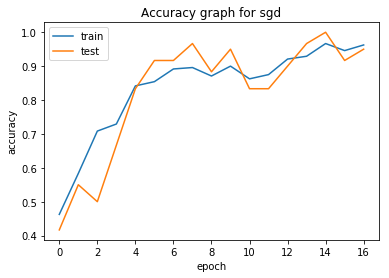

In [10]:
# summarize history for accuracy
plt.plot(sgd_history.history['acc'])
plt.plot(sgd_history.history['val_acc'])
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy graph for sgd')
plt.show()

The accuracy is satisfying !
Now, let's test the model on a disk and a triangle

In [15]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(sgd_classifier.predict(X_test))
[X_test,v] = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
print(sgd_classifier.predict(X_test))

[[0. 1. 0.]]
[[0. 0. 1.]]


The results of the test are correct

Now, lets Build and train a classifier optimised with Adam 

In [5]:
#Adam
adam_classifier = Sequential()
adam_classifier.add(Dense(3, input_shape=(5184,), activation='softmax'))
adam_classifier.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
adam_history = adam_classifier.fit(X_train, to_categorical(Y_train), epochs=17, batch_size=64, validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/17
240/240 [==============================] - 1s 5ms/step - loss: 2.7524 - acc: 0.3333 - val_loss: 1.8353 - val_acc: 0.4667
Epoch 2/17
240/240 [==============================] - 0s 195us/step - loss: 1.7978 - acc: 0.4667 - val_loss: 2.4760 - val_acc: 0.2167
Epoch 3/17
240/240 [==============================] - 0s 223us/step - loss: 1.6407 - acc: 0.3917 - val_loss: 0.9015 - val_acc: 0.5833
Epoch 4/17
240/240 [==============================] - 0s 287us/step - loss: 1.1200 - acc: 0.4333 - val_loss: 0.6394 - val_acc: 0.7333
Epoch 5/17
240/240 [==============================] - 0s 326us/step - loss: 0.7970 - acc: 0.5958 - val_loss: 0.9531 - val_acc: 0.4833
Epoch 6/17
240/240 [==============================] - 0s 288us/step - loss: 0.6355 - acc: 0.7125 - val_loss: 0.6194 - val_acc: 0.6667
Epoch 7/17
240/240 [==============================] - 0s 288us/step - loss: 0.6497 - acc: 0.7333 - val_loss: 0.4999 - val_acc: 0.8833
Epoch 8/17
240/240 

Represting the accuracy according to the number of epoches

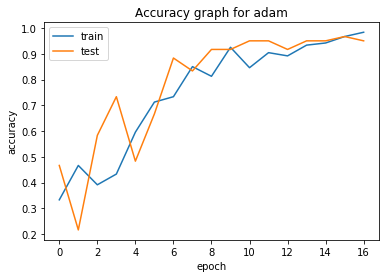

In [11]:
# summarize history for accuracy
plt.plot(adam_history.history['acc'])
plt.plot(adam_history.history['val_acc'])
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy graph for adam')
plt.show()

The result is satifying and even better than with SGD. In the next box, When we test it with a disk and a traigle and the results are true

In [16]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(adam_classifier.predict(X_test))
[X_test,v] = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
print(adam_classifier.predict(X_test))

[[0. 1. 0.]]
[[0. 0. 1.]]


# 4    Visualization of the Solution

We  would  like  to  visualize  the  weights  of  the  linear  classifier.   Check  the  output  of  the  function
model.get_weights()
:  The first part corresponds to the matrix of the classifier.  Its columns have
the same size as the input images, because Keras uses vector-matrix multiplications instead of matrix-
vector multiplications.
†
Visualize the 3 columns as images.
Hint:  Only two (short) lines of code are required to visualize one column.

In [40]:
weights = adam_classifier.get_weights()[0]

In [41]:
weights.shape

(5184, 3)

In [42]:
weights

array([[-0.0224355 ,  0.01908931,  0.00563025],
       [-0.00516427, -0.01733563, -0.01964469],
       [ 0.01604402,  0.00224698, -0.02971183],
       ...,
       [ 0.00904593, -0.0247897 , -0.0026095 ],
       [-0.00977134,  0.02732723, -0.01867411],
       [ 0.02908256,  0.02332413, -0.00974028]], dtype=float32)

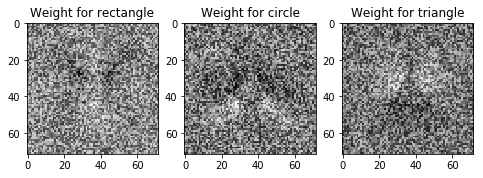

In [81]:
column1=np.array([])
column2=np.array([])
column3=np.array([])
for mini in weights :
    column1 = np.append(column1, mini[0])
    column2 = np.append(column2, mini[1])
    column3 = np.append(column3, mini[2])
fig=plt.figure(figsize=(8, 8))
a=fig.add_subplot(1, 3, 1)
plt.imshow(column1.reshape(72,72), cmap='gray')
a.set_title('Weight for rectangle')
b=fig.add_subplot(1, 3, 2)
plt.imshow(column2.reshape(72,72), cmap='gray')
b.set_title('Weight for circle')
c=fig.add_subplot(1, 3, 3)
plt.imshow(column3.reshape(72,72), cmap='gray')
c.set_title('Weight for triangle')
plt.show()

# 5    A More Difficult Classification Problem
Now, the shapes are allowed to move within the images and change dimensions.  You can generate
the new training set with:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Retrain your linear classifier on this new training set.  Add the
metrics=[’accuracy’]
parameter
when calling the
compile
function to get the classification error in addition to the loss value.
You can generate a test set by calling:
[X_test, Y_test] = generate_test_set_classification()
and evaluate your classifier on this test set by calling:
model.evaluate(X_test, Y_test)
†
Train a convolutional (not-to-)deep network on this new dataset.  What is the value of the loss
function on this test set when using your deep network?
Hints:  You can limit yourself to 1 convolutional layer with 16 5×5 filters, 1 pooling layer, and one fully connected layer, but you are free to use any other architecture.  You are allowed to increase
the number of training samples if you want to.

We build the training set

In [148]:
[X_train_True, Y_train_True] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We reshape the training set

In [171]:
X_train_True = X_train_True.reshape(X_train.shape[0], 72, 72, 1)
X_train_True = X_train_True.astype('float32')
print(X_train_True.shape)

(300, 72, 72, 1)


We build a CNN

In [186]:
CNN_classifier = Sequential()
#Covolutional layer 1 : filter size :5*5 with 16 mappings, activation: relu  
CNN_classifier.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72, 72, 1)))
print(CNN_classifier.output_shape)
#Pooling using maxpooling  
CNN_classifier.add(MaxPooling2D(pool_size=(5, 5)))
print(CNN_classifier.output_shape)
#Regularisation using drop out with a percentage of 25%
from keras.layers import Dropout
CNN_classifier.add(Dropout(0.25))
print(CNN_classifier.output_shape)
#Flatten the data from a matrix format to a vectorial format
from keras.layers import Flatten
CNN_classifier.add(Flatten())
print(CNN_classifier.output_shape)
#Add a fully connected layer activated with relu, regularized with dropout (50%)
from keras.layers import Dense
CNN_classifier.add(Dense(128, activation='relu'))
print(CNN_classifier.output_shape)
CNN_classifier.add(Dropout(0.5))
# The final FC Layer activated with a sigmoid function : softmax
CNN_classifier.add(Dense(3, activation='softmax'))
print(CNN_classifier.output_shape)

(None, 68, 68, 16)
(None, 13, 13, 16)
(None, 13, 13, 16)
(None, 2704)
(None, 128)
(None, 3)


We train the CNN

In [187]:
CNN_classifier.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
CNN_history = CNN_classifier.fit(X_train_True, to_categorical(Y_train_True), epochs=20, batch_size=32, validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 3s 11ms/step - loss: 1.1506 - acc: 0.3875 - val_loss: 1.0711 - val_acc: 0.4333
Epoch 2/20
240/240 [==============================] - 1s 5ms/step - loss: 1.0798 - acc: 0.4000 - val_loss: 1.0127 - val_acc: 0.6500
Epoch 3/20
240/240 [==============================] - 1s 4ms/step - loss: 0.9806 - acc: 0.6250 - val_loss: 0.9567 - val_acc: 0.7667
Epoch 4/20
240/240 [==============================] - 1s 4ms/step - loss: 0.9164 - acc: 0.6667 - val_loss: 0.8873 - val_acc: 0.6833
Epoch 5/20
240/240 [==============================] - 1s 4ms/step - loss: 0.8165 - acc: 0.7125 - val_loss: 0.8000 - val_acc: 0.7333
Epoch 6/20
240/240 [==============================] - 1s 4ms/step - loss: 0.7788 - acc: 0.7083 - val_loss: 0.7735 - val_acc: 0.7167
Epoch 7/20
240/240 [==============================] - 1s 4ms/step - loss: 0.7351 - acc: 0.7417 - val_loss: 0.7414 - val_acc: 0.7167
Epoch 8/20
240/240 [==========

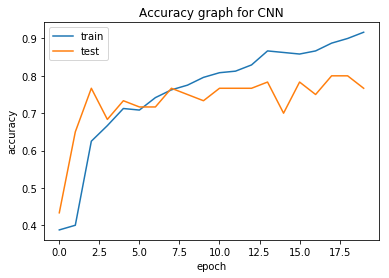

In [188]:
# summarize history for accuracy
plt.plot(CNN_history.history['acc'])
plt.plot(CNN_history.history['val_acc'])
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy graph for CNN')
plt.show()

The result is acceptable, but way bellow the former models

In [505]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [190]:
X_test = X_test.reshape(X_train.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')
CNN_classifier.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 2ms/step


[0.6645197772979736, 0.73]

# 6    A Regression Problem
The task now is to predict the image locations of the vertices of a triangle, given an image of this
triangle.  You can generate a training set by calling:
[X_train, Y_train] = generate_dataset_regression(300, 20)
2
You  can  visualize  a  training  sample  (or  a  prediction)  by  calling  the
visualize_prediction
function:
visualize_prediction(X_train[0], Y_train[0])
†
Build and train a regressor on this data.  Evaluate your solution on the test set generated by
[X_test, Y_test] = generate_test_set_regression()
Hint:  You may have to normalize somehow the vertices in
Y_train
and
Y_test
before training
and testing...

Generate the training set

In [191]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Build the model with 5layers and compile it

In [217]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu',name='node1'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',name='dense2'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',name='dense3'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',name='dense4'))

# The Output Layer :
NN_model.add(Dense(6, kernel_initializer='normal',activation='linear',name='dense5'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
node1 (Dense)                (None, 128)               663680    
_________________________________________________________________
dense2 (Dense)               (None, 256)               33024     
_________________________________________________________________
dense3 (Dense)               (None, 256)               65792     
_________________________________________________________________
dense4 (Dense)               (None, 256)               65792     
_________________________________________________________________
dense5 (Dense)               (None, 6)                 1542      
Total params: 829,830
Trainable params: 829,830
Non-trainable params: 0
_________________________________________________________________


Train the model

In [220]:
history = NN_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split = 0.2)
NN_model.summary()

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2125 - mean_squared_error: 0.0685 - val_loss: 0.2166 - val_mean_squared_error: 0.0718
Epoch 2/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2083 - mean_squared_error: 0.0675 - val_loss: 0.2292 - val_mean_squared_error: 0.0780
Epoch 3/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2119 - mean_squared_error: 0.0692 - val_loss: 0.2246 - val_mean_squared_error: 0.0782
Epoch 4/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2140 - mean_squared_error: 0.0708 - val_loss: 0.2307 - val_mean_squared_error: 0.0794
Epoch 5/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2211 - mean_squared_error: 0.0739 - val_loss: 0.2150 - val_mean_squared_error: 0.0704
Epoch 6/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2106 - mean_squared_error: 0.0687 - val_loss: 0.2317 - val_mean_squar

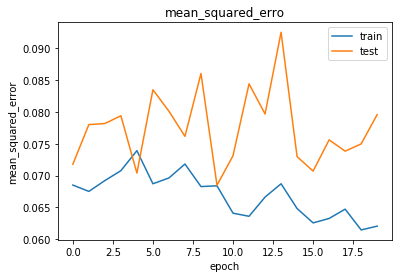

In [221]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['train', 'test'])
plt.title('mean_squared_erro')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.show()

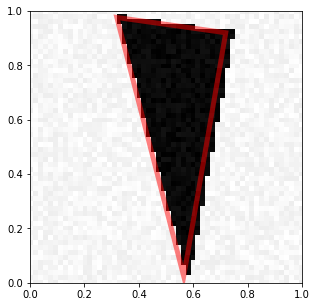

In [225]:
visualize_prediction(X_train[0], Y_train[0])

In [226]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


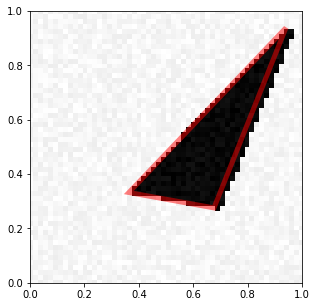

In [227]:
visualize_prediction(X_test[0], Y_test[0])

In [229]:
predictions = NN_model.predict(X_test)

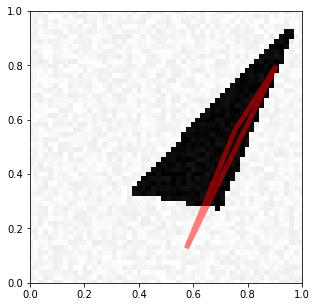

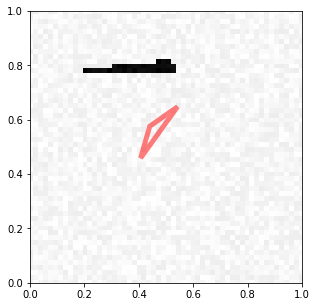

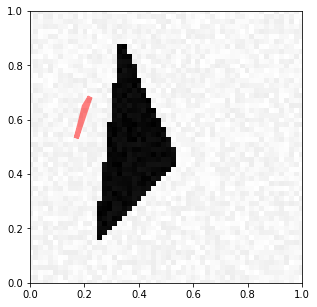

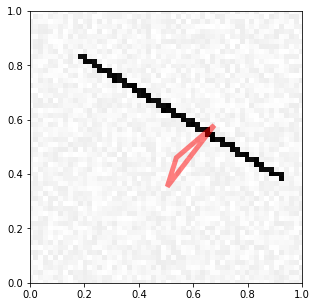

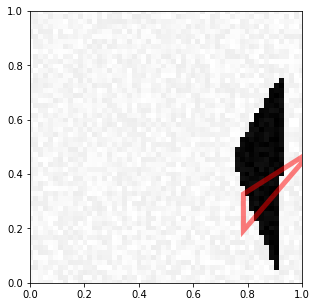

In [233]:
for i in range(5):
    visualize_prediction(X_test[i], predictions[i])

The model can be improved

# 7 Image Denoising
Implement a hourglass network for denoising:  Modifying the
generate_a_*
functions to generate
pairs of images, where one image has noise with random amplitude, and the second image has the
same content but without the noise.  Train your network to predict a noise-free image given a noisy
image as input.

Fonction that generates two images : the first one without noise and the second one with noise

Generating the new drawing funcion

In [508]:
def generate_a_drawing(figsize, U, V, noise):
    noise = np.random.random(1)[0]*100
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata1 = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata, imdata1 , noise

Exemple of the fonction resuls for a rectangle

In [509]:
figsize = 1.0    
U = np.zeros(4)
V = np.zeros(4)
free_location = False
if free_location:
    corners = np.random.random(4)
    top = max(corners[0], corners[1])
    bottom = min(corners[0], corners[1])
    left = min(corners[2], corners[3])
    right = max(corners[2], corners[3])
else:
    side = (0.3 + 0.7 * np.random.random()) * figsize
    top = figsize/2 + side/2
    bottom = figsize/2 - side/2
    left = bottom
    right = top
U[0] = U[1] = top
U[2] = U[3] = bottom
V[0] = V[3] = left
V[1] = V[2] = right

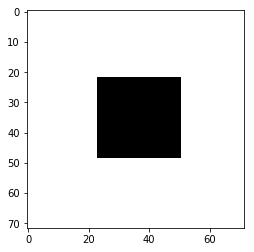

In [510]:
X = generate_a_drawing(figsize, U, V, 0)
X0 = X[0].reshape(72,72)
plt.imshow(X0,cmap='gray')


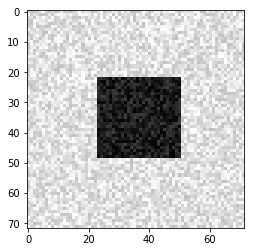

In [511]:
X1 = X[1].reshape(72,72)
plt.imshow(X1,cmap='gray')

Fonction that generates the new training dataset 

In [512]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Xnoise = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            temp = generate_a_rectangle(noise, free_location)
            X[i] = temp[0]
            Xnoise[i] = temp[1]
        elif category == 1: 
            temp = generate_a_disk(noise, free_location)
            X[i] = temp[0]
            Xnoise[i] = temp[1]
        else:
            temp = generate_a_triangle(noise, free_location)
            [X[i], V] = [temp[0][0],temp[1]]
            [Xnoise[i], V] = [temp[0][1],temp[1]]
        Y[i] = category
    return [Xnoise, X]
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Building the model

In [513]:
inputs = Input(shape=(72, 72,1))
conv1a = Conv2D(16, 3, activation='relu', padding = 'same')(inputs)
conv1b = Conv2D(16, 3, activation='relu', padding = 'same')(conv1a)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1b)
conv2a = Conv2D(32, 3, activation='relu', padding = 'same')(pool1)
conv2b = Conv2D(32, 3, activation='relu', padding = 'same')(conv2a)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2b)
conv3a = Conv2D(64, 3, activation='relu', padding = 'same')(pool2)
conv3b = Conv2D(64, 3, activation='relu', padding = 'same')(conv3a)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3b)
up4 = UpSampling2D(size=(2, 2))(pool3)
up_conv4 = Conv2D(64, 2, activation='relu', padding = 'same')(up4)
conv4b = Conv2D(64, 3, activation='relu', padding = 'same')(up_conv4)
conv4c = Conv2D(64, 3, activation='relu', padding = 'same')(conv4b)
up5 = UpSampling2D(size=(2, 2))(conv4c)
up_conv5 = Conv2D(32, 2, activation='relu', padding = 'same')(up5)
merge5 = Concatenate(axis=3)([conv2b, up_conv5])
conv5b = Conv2D(32, 3, activation='relu', padding = 'same')(merge5)
conv5c = Conv2D(32, 3, activation='relu', padding = 'same')(conv5b)
up6 = UpSampling2D(size=(2, 2))(conv5c)
up_conv6 = Conv2D(64, 2, activation='relu', padding = 'same')(up6)
merge6 = Concatenate(axis=3)([conv1b, up_conv6])
conv6b = Conv2D(64, 3, activation='relu', padding = 'same')(merge6)
conv6c = Conv2D(64, 3, activation='relu', padding = 'same')(conv6b)
conv7 = Conv2D(1, 1, activation="sigmoid")(conv6c)


Coder = Model(inputs=inputs, outputs=conv7)

Coder.compile(optimizer = 'adam',loss = 'binary_crossentropy')

In [514]:
X_train0 = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train0 = Y_train.reshape(Y_train.shape[0], 72, 72, 1)
history = Coder.fit(X_train0,Y_train0,epochs=3, batch_size=32)

Train on 240 samples, validate on 60 samples
Epoch 1/3
240/240 [==============================] - 56s 235ms/step - loss: -2265.5509 - val_loss: -3136.6576
Epoch 2/3
240/240 [==============================] - 59s 246ms/step - loss: -3216.8973 - val_loss: -3136.6570
Epoch 3/3
240/240 [==============================] - 57s 236ms/step - loss: -3216.8965 - val_loss: -3136.6570


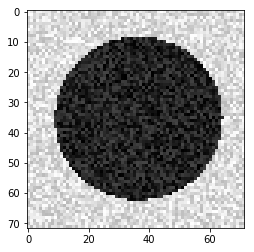

In [515]:
X = generate_a_disk(noise=0.0, free_location=False)[1]
plt.imshow(X.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

(1, 72, 72, 1)


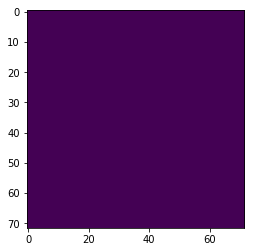

In [516]:
Y_predicted= Coder.predict(X.reshape(1, 72, 72, 1))
print(Y_predicted.shape)
Y_predicted = Y_predicted.reshape(72, 72)
plt.imshow(Y_predicted)

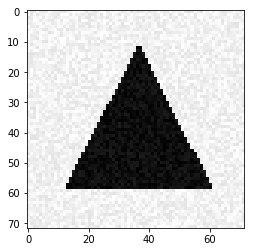

In [517]:
X = generate_a_triangle(noise=0.0, free_location=False)[0][1]
plt.imshow(X.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

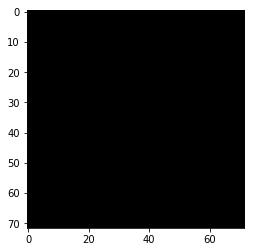

In [518]:
Y_predicted= Coder.predict(X.reshape(1, 72, 72, 1))
Y_predicted = Y_predicted.reshape(72, 72)
plt.imshow(Y_predicted, cmap='gray')